In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import struct
import pandas as pd
import seaborn as sns
from math import e
sns.set(rc={'figure.figsize':(24, 13.5)}, font_scale = 2.7)


In [184]:
name = 'euroc-piccard'
direction = 'negx'
name = 'argos-constanca'
direction = 'posy'
#name = 'argos-felix'
#direction = 'negy'
name = 'argos-toyger'
direction = 'posy'
#name = 'euler_explosion'
#name = 'flight_2'
#direction = 'posy'

log = '../../cats-logs/log_parsing/output/' + name + '/processed/'
log_imu = log + name + ' - imu_processed.csv'
log_baro = log + name + ' - baro_processed.csv'
log_filtered = log + name + ' - filtered_data_info_processed.csv'

imu_data_df = pd.read_csv(log_imu) 
baro_data_df = pd.read_csv(log_baro) 
filtered_data_df = pd.read_csv(log_filtered) 

imu_0 = imu_data_df.loc[imu_data_df['id'] == 'IMU0']
imu_1 = imu_data_df.loc[imu_data_df['id'] == 'IMU1']

baro_0 = baro_data_df.loc[baro_data_df['id'] == 'BARO0']
baro_1 = baro_data_df.loc[baro_data_df['id'] == 'BARO1']
baro_2 = baro_data_df.loc[baro_data_df['id'] == 'BARO2']


In [185]:
def prediction_step(x_bar, u_bar, P_bar, Ts, Q):
    # This needs to be moved in the include 
    Ad = np.array([[1, Ts, Ts*Ts/2],[0, 1, Ts], [0, 0, 1]])
    Gd = np.array([[Ts, Ts*Ts/2], [1, Ts], [0, 1]])
    Bd = np.array([[Ts*Ts/2], [Ts], [0]])
    # finished including
    
    x_hat = np.matmul(Ad, x_bar) + Bd * u_bar
    P_hat = np.matmul(np.matmul(Ad, P_bar), np.transpose(Ad)) + np.matmul(np.matmul(Gd, Q), np.transpose(Gd))
    return x_hat, P_hat

def update_step(x_hat, P_hat, measurement, R):
    # Again, needs to be moved into the include
    H = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0]])
    # Finished including
    
    K = np.matmul(np.matmul(P_hat, np.transpose(H)), np.linalg.pinv(np.matmul(np.matmul(H, P_hat), np.transpose(H))+R)) # K = P_hat*H'*(H*P_hat*H'+R)^-1
    #K = np.array([[0.0090859386, 0.0090859386, 0.0090859386], [0.0125381065, 0.0125381065, 0.0125381065], [0.000748688836, 0.000748688836, 0.000748688836]])
    #K = np.array([[0.00900859386, 0.00900859386, 0.00900859386], [0.0123381065, 0.0123381065, 0.0123381065], [0.000448688836, 0.000448688836, 0.000448688836]])
    #K = np.array([[0.00908229, 0.00908229, 0.00908229], [0.01253863, 0.01253863, 0.01253863], [0.00072149, 0.00072149, 0.00072149]])
    
    x_bar = x_hat + np.matmul(K, (measurement - np.matmul(H, x_hat)))
    
    P_bar = np.matmul((np.eye(3) - np.matmul(K, H)), P_hat)

    return x_bar, P_bar, K

def update_step_simple(x_hat, P_hat, measurement, R):
    # Again, needs to be moved into the include
    H = np.array([[1, 0, 0]])
    # Finished including
    
    K = np.matmul(np.matmul(P_hat, np.transpose(H)), np.linalg.pinv(np.matmul(np.matmul(H, P_hat), np.transpose(H))+R)) # K = P_hat*H'*(H*P_hat*H'+R)^-1
    #K = np.array([[0.0090859386, 0.0090859386, 0.0090859386], [0.0125381065, 0.0125381065, 0.0125381065], [0.000748688836, 0.000748688836, 0.000748688836]])
    #K = np.array([[0.00900859386, 0.00900859386, 0.00900859386], [0.0123381065, 0.0123381065, 0.0123381065], [0.000448688836, 0.000448688836, 0.000448688836]])
    #K = np.array([[0.00908229, 0.00908229, 0.00908229], [0.01253863, 0.01253863, 0.01253863], [0.00072149, 0.00072149, 0.00072149]])
    
    x_bar = x_hat + np.matmul(K, (measurement - np.matmul(H, x_hat)))
    
    P_bar = np.matmul((np.eye(3) - np.matmul(K, H)), P_hat)

    return x_bar, P_bar, K



def calculate_height(P0, P, T):

    return (-((P/P0)**(1/5.257)-1)*(T+273.15)/0.0065)

def soft_reset():
    P = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    return P, P

    
    
def R_factor(value):
    lower_bound = 20
    upper_bound = 100
    f_lower_bound = 0.1
    f_upper_bound = 1

    
    m = (f_lower_bound - f_upper_bound)/(lower_bound - upper_bound)
    b = f_upper_bound - m*upper_bound
    if(value < lower_bound):
        return f_lower_bound**5
    elif (value < upper_bound):
        return ((m*value + b)**5)
    else:
        return f_upper_bound

    
def moving_average(a, n=20):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [186]:
def check_flight_phase(old_flight_phase, x, imu_raw, acc, memory):
    acc_threshold = 4000*4000/(1024*1024)
    LIFTOFF_SAFETY_COUNTER = 10
    COASTING_SAFETY_COUNTER = 30
    APOGEE_SAFETY_COUNTER = 30
    PARACHUTE_DESCENT_SPEED = -100
    PARACHUTE_SAFETY_COUNTER = 50
    MAIN_ALTITUDE = 300
    MAIN_SAFETY_COUNTER = 10
    
    flight_phase = old_flight_phase
    mem = memory;
    
    if(old_flight_phase == 'READY'):
        tag = 1
        acc_abs = imu_raw.Ax*imu_raw.Ax + imu_raw.Ay*imu_raw.Ay + imu_raw.Az*imu_raw.Az
        #print(acc_abs)
        if(acc_abs > acc_threshold):
            mem[0] = mem[0] + 1
        else:
            mem[0] = 0
            
        if(mem[0] > LIFTOFF_SAFETY_COUNTER):
            flight_phase = 'THRUSTING_1'
            tag = 2
            mem[0] = 0
            
    elif(old_flight_phase == 'THRUSTING_1'):
        tag = 2
        if (acc < 0):
            mem[0] = mem[0] + 1;
        else:
            mem[0] = 0;
            
        if(mem[0] > COASTING_SAFETY_COUNTER):
            flight_phase = 'COASTING'
            tag = 3
            mem[0] = 0
            
    elif(old_flight_phase == 'COASTING'):
        tag = 3
        if (x[1] < 0):
            mem[0] = mem[0] + 1;
        else:
            mem[0] = 0;
            
        if(mem[0] > APOGEE_SAFETY_COUNTER):
            flight_phase = 'APOGEE'
            tag = 4
            mem[0] = 0
    
    elif(old_flight_phase == 'APOGEE'):
        tag = 4
        if (x[1] > PARACHUTE_DESCENT_SPEED):
            mem[0] = mem[0] + 1;
        else:
            mem[0] = 0;
            
        if(mem[0] > PARACHUTE_SAFETY_COUNTER):
            flight_phase = 'DROGUE'
            tag = 5
            mem[0] = 0
          
    elif(old_flight_phase == 'DROGUE'):
        tag = 5
        if (x[0] < MAIN_ALTITUDE):
            mem[0] = mem[0] + 1;
        else:
            mem[0] = 0;
            
        if(mem[0] > MAIN_SAFETY_COUNTER):
            flight_phase = 'MAIN'
            tag = 6
            mem[0] = 0
    else:
        tag = 6
    
    
    
    return flight_phase, tag, mem

In [187]:
import numpy as np
Ts = 1/100

x_bar_old = np.array([[0],[0],[0]])
P_bar_old = np.array([[0.01, 0, 0],[0, 0.01, 0], [0, 0, 0.01]])
height_old = np.zeros(len(baro_0))
velocity_old = np.zeros(len(baro_0))
acc_offset_old = np.zeros(len(baro_0))

x_bar_new = np.array([[0],[0],[0]])
P_bar_new = np.array([[0.01, 0, 0],[0, 0.01, 0], [0, 0, 0.01]])
height_new = np.zeros(len(baro_0))
velocity_new = np.zeros(len(baro_0))
acc_offset_new = np.zeros(len(baro_0))

x_bar_simpl = np.array([[0],[0],[0]])
P_bar_simpl = np.array([[0.01, 0, 0],[0, 0.01, 0], [0, 0, 0.01]])
height_simpl = np.zeros(len(baro_0))
velocity_simpl = np.zeros(len(baro_0))
acc_offset_simpl = np.zeros(len(baro_0))

height_acc = np.zeros(len(baro_0))
velocity_acc = np.zeros(len(baro_0))
velocity_baro = np.zeros(len(baro_0))
flight_phase_log = np.zeros(len(baro_0))




P0 = np.mean([[baro_0.iloc[0].P], [baro_1.iloc[0].P], [baro_2.iloc[0].P]])
time = np.zeros(len(baro_0))
agl = np.zeros(len(baro_0))
acc = np.zeros(len(baro_0))
abs_acc = np.zeros(len(baro_0))
R_array = np.zeros(len(baro_0))
i = 0

R_old = 9*np.eye(3)
Q_old = np.array([[0.004, 0], [0, 0.000001]])

STD_NOISE_BARO_INITIAL = 9
STD_NOISE_BARO = 900000

R_value = 9000000
Q_new = np.array([[0.004, 0], [0, 0.000001]])


include_changing_R = 1
R_temp = R_value;
median_filter_array = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
median_counter = 0

for k in range(len(baro_2)-10):
    abs_acc[k] = (imu_1.iloc[k].Ax**2 + imu_1.iloc[k].Ay**2 + imu_1.iloc[k].Az**2)**0.5
    
median_filtered = moving_average(abs_acc, 50)

flight_phase = 'READY'
old_flight_phase = 'READY'
memory = np.array([0, 0])
memory[0] = 0
memory[1] = 0


for k in range(len(baro_2)-50):
    
        
    # Check Flight phase
    [flight_phase, tag, memory] = check_flight_phase(flight_phase, x_hat_new, imu_0.iloc[k], u, memory)
    
    
    # reset kf on ready state
    if((flight_phase == 'THRUSTING_1') and (flight_phase != old_flight_phase)):
        [P_hat_new, P_bar_new] = soft_reset()     
    
    
    y1 = calculate_height(P0, float(baro_0.iloc[k].P), 25.0)
    y2 = calculate_height(P0, float(baro_1.iloc[k].P), 25.0)
    y3 = calculate_height(P0, float(baro_2.iloc[k].P), 25.0)
    y = np.array([[y1], [y2], [y3]])
    
    y_simpl = (y1 + y2 + y3) / 3

    if(direction == 'negx'):
        u = -(imu_0.iloc[k].Ax + imu_1.iloc[k].Ax)/2*9.81 - 9.81
    elif(direction == 'posy'):
        u = (imu_0.iloc[k].Ay + imu_1.iloc[k].Ay)/2*9.81 - 9.81
    elif(direction == 'negy'):
        u = -(imu_0.iloc[k].Ay + imu_1.iloc[k].Ay)/2*9.81 - 9.81
        
    median_filter_array[median_counter] = u
    median_counter = median_counter+1
    if(median_counter % 9 == 0):
        median_counter = 0;
        
    u = np.median(median_filter_array)
        
    if(flight_phase != 'READY' and flight_phase != 'THRUSTING_1' and flight_phase != 'COASTING'):
        u = 0
        
    if(flight_phase == 'READY'):
        R_new = STD_NOISE_BARO_INITIAL
    elif(flight_phase == 'THRUSTING_1'):
        R_new = STD_NOISE_BARO
    elif(flight_phase == 'COASTING'):
        R_new = STD_NOISE_BARO*R_factor(x_bar_new[1]);
    
    R_array[k] = R_new
    
    R_new_mat = R_new*np.eye(3)
    

        

    [x_hat_old, P_hat_old] = prediction_step(x_bar_old, u, P_bar_old, Ts, Q_old)
    [x_hat_new, P_hat_new] = prediction_step(x_bar_new, u, P_bar_new, Ts, Q_new)
    [x_hat_simpl, P_hat_simpl] = prediction_step(x_bar_simpl, u, P_bar_simpl, Ts, Q_new)
    #x_hat_simpl[2] = 0;
    
    [x_bar_old, P_bar_old, K] = update_step(x_hat_old, P_hat_old, y, R_old)
    [x_bar_new, P_bar_new, K] = update_step(x_hat_new, P_hat_new, y, R_new_mat)
    [x_bar_simpl, P_bar_simpl, K] = update_step(x_hat_simpl, P_hat_simpl, y_simpl, R_new)
    #x_bar_simpl[2] = 0;

        
    #integration
    if(k != 0):
        velocity_acc[k] = velocity_acc[k-1] + u*Ts
        height_acc[k] = height_acc[k-1] + velocity_acc[k]*Ts
        velocity_baro[k] = (y_simpl - agl[k-1])/Ts
        
        
        
    old_flight_phase = flight_phase
        
        
    agl[k] = y_simpl
    acc[k] = u
    abs_acc[k] = (imu_1.iloc[k].Ax**2 + imu_1.iloc[k].Ay**2 + imu_1.iloc[k].Az**2)**0.5
    height_old[k] = x_bar_old[0]
    velocity_old[k] = x_bar_old[1]
    acc_offset_old[k] = x_bar_old[2]
    height_new[k] = x_bar_new[0]
    velocity_new[k] = x_bar_new[1]
    acc_offset_new[k] = x_bar_new[2]
    height_simpl[k] = x_bar_simpl[0]
    velocity_simpl[k] = x_bar_simpl[1]
    acc_offset_simpl[k] = x_bar_simpl[2]
    time[k] = float(baro_2.iloc[k].ts)
    flight_phase_log[k] = tag

In [188]:
plot_limits = [87500, 92500]
plot_limits = [0, 1500]
plot_limits_y = [-20, 500]
velocity_new[k] < 0

True

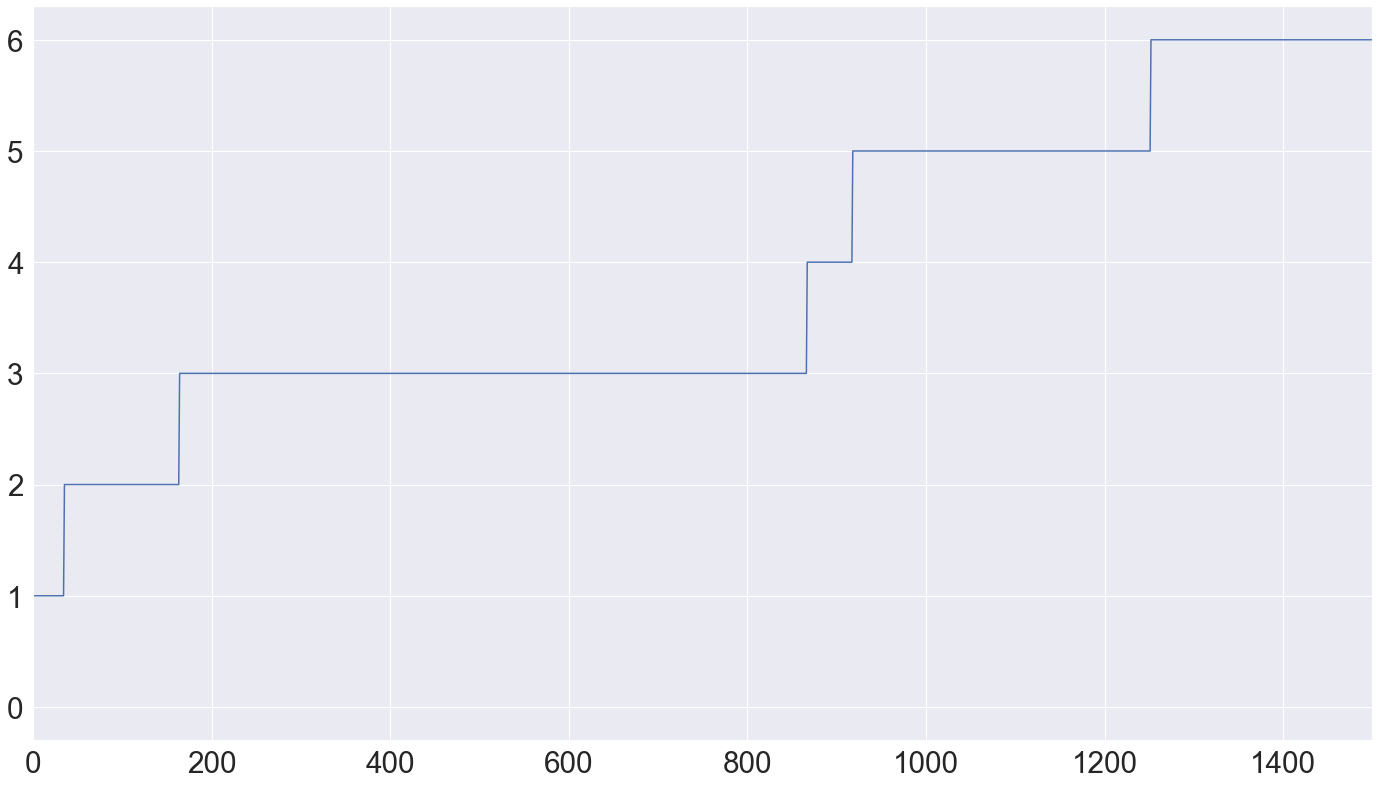

In [189]:
plt.plot(flight_phase_log)
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

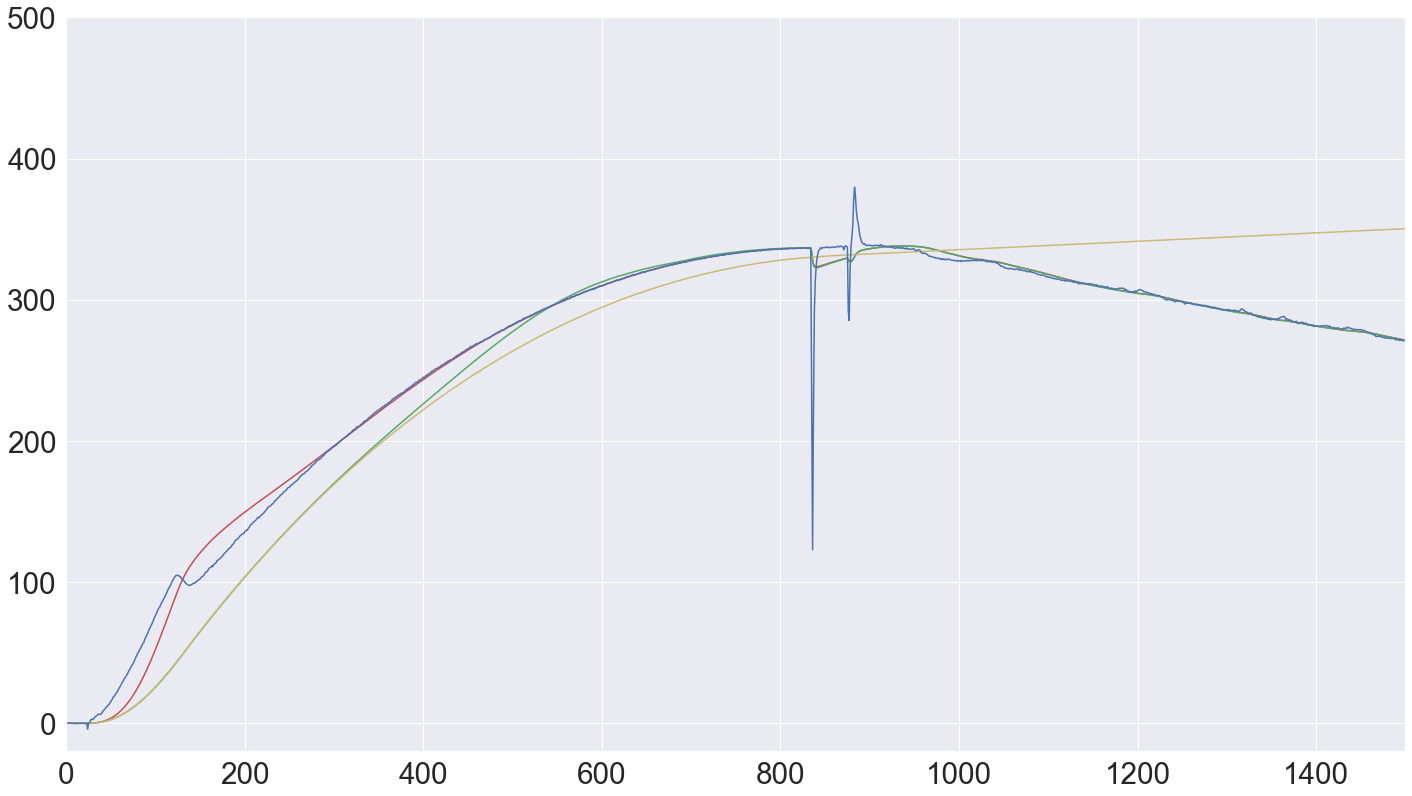

In [190]:
plt.plot(height_old, 'r')
plt.plot(height_new, 'g')
#plt.plot(height_simpl, 'g')
plt.plot(height_acc, 'y')
plt.plot(agl, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
axes.set_ylim(plot_limits_y)
plt.show()

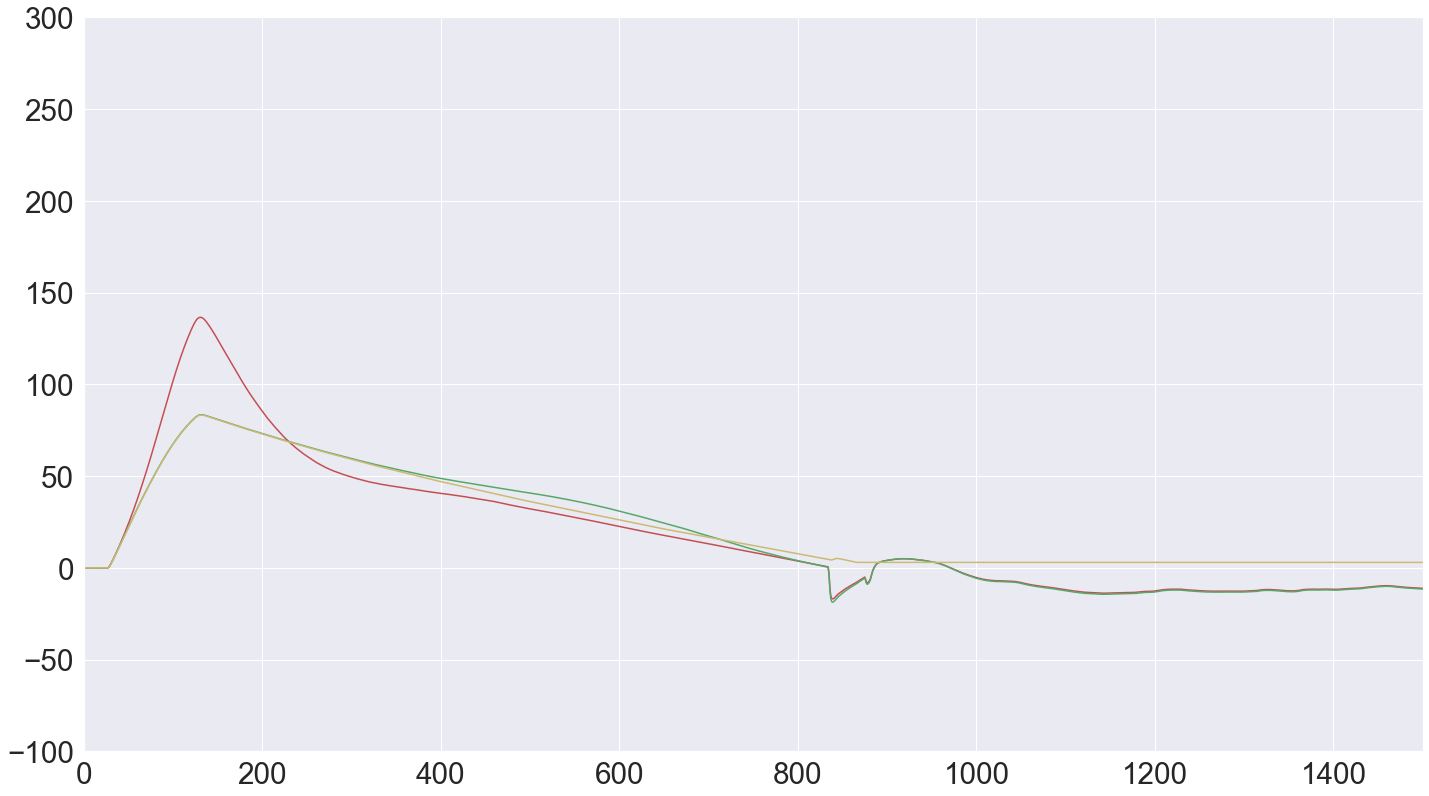

In [191]:
plt.plot(velocity_old, 'r')
plt.plot(velocity_new, 'g')
#plt.plot(velocity_simpl, 'g')
plt.plot(velocity_acc, 'y')
#plt.plot(velocity_baro, 'b')
axes = plt.gca()
plot_limits_y = [-100, 300]
axes.set_xlim(plot_limits)
axes.set_ylim(plot_limits_y)
plt.show()

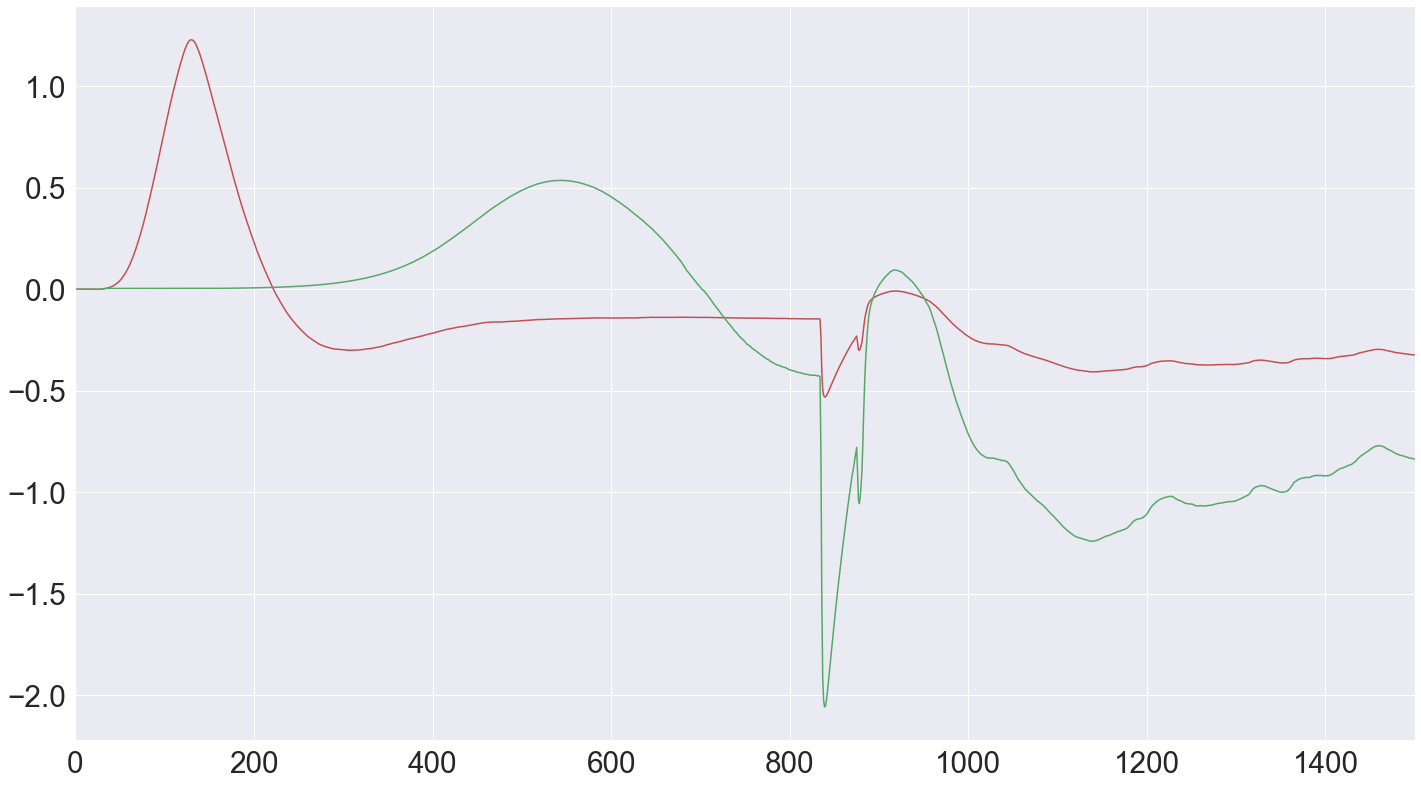

In [192]:
plt.plot(acc_offset_old, 'r')
plt.plot(acc_offset_new, 'g')
#plt.plot(acc_offset_simpl, 'g')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

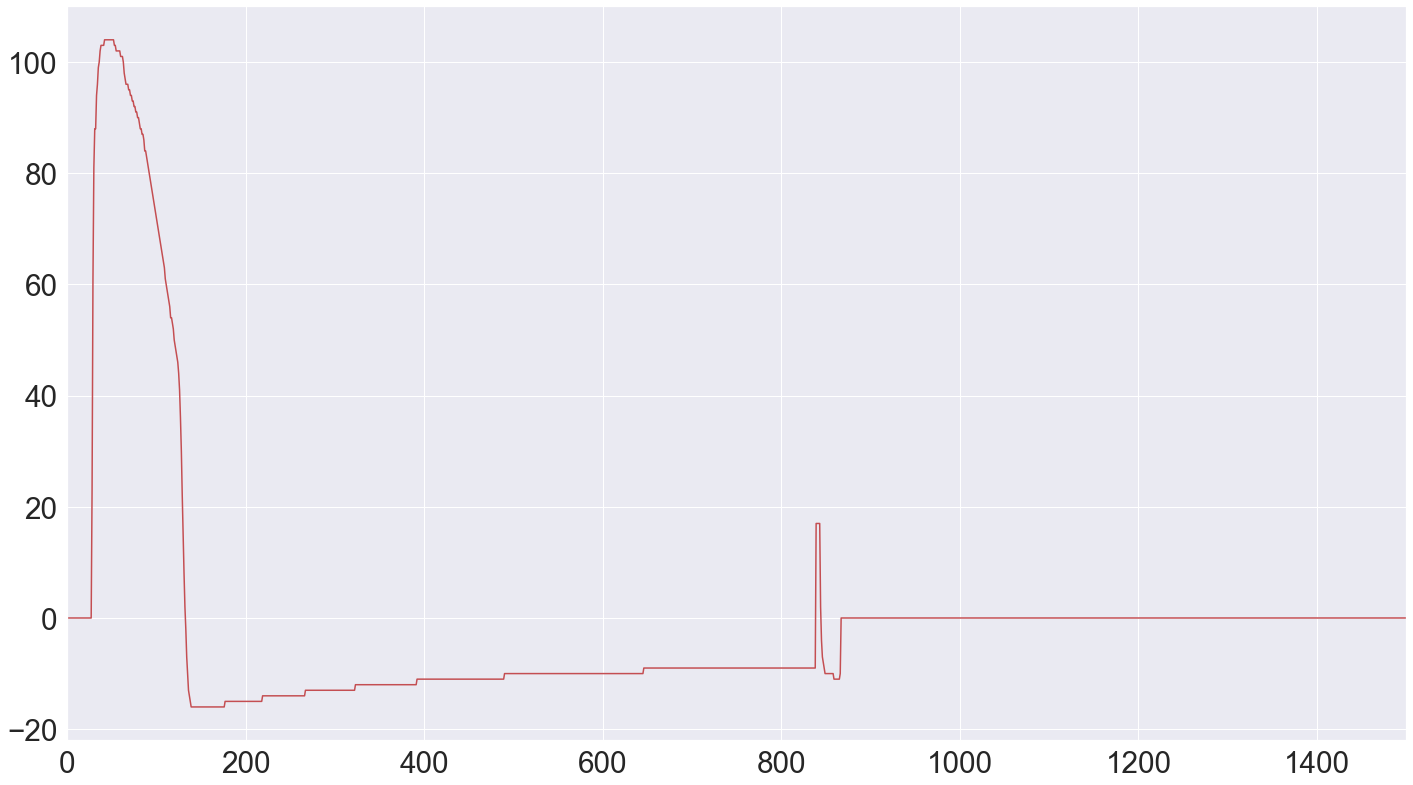

In [193]:
plt.plot(acc, 'r')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

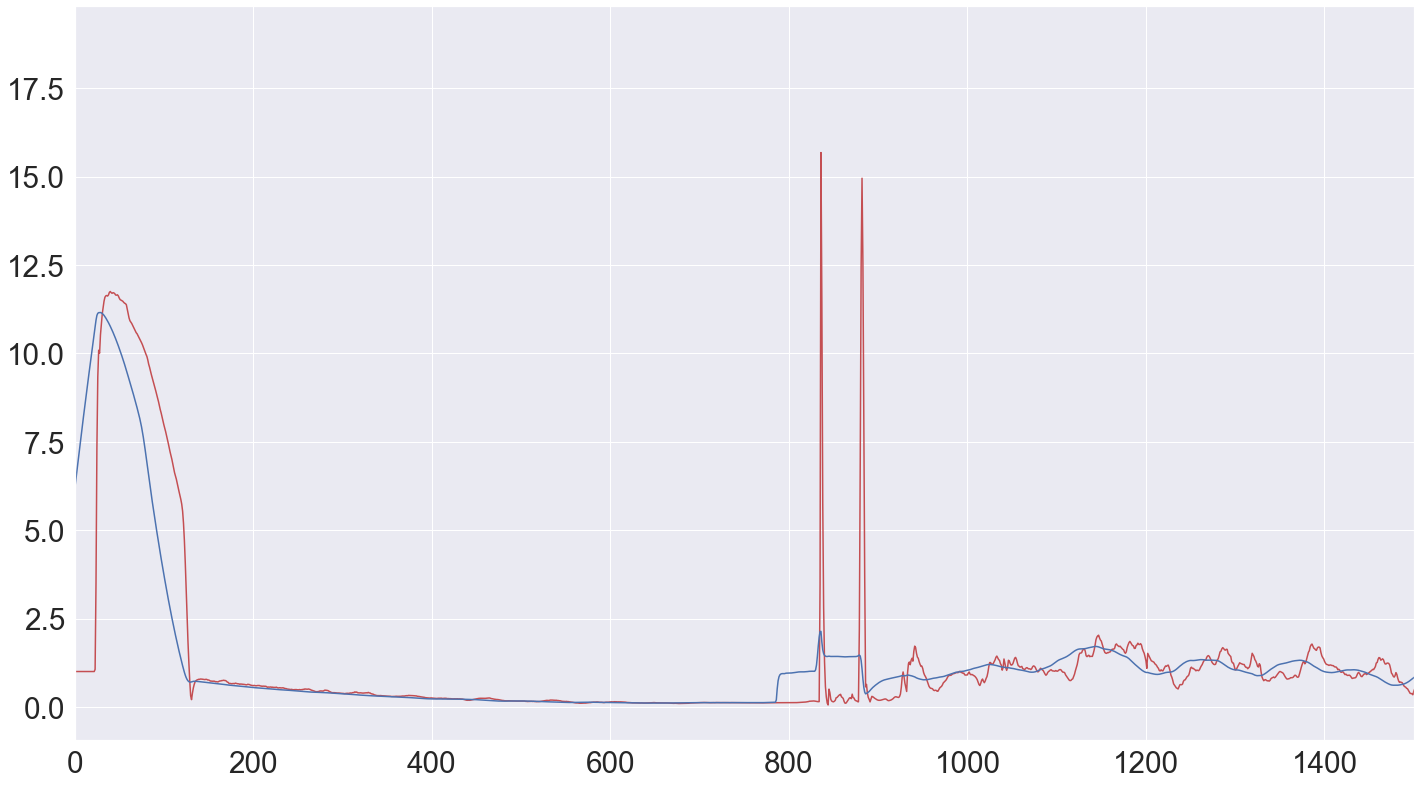

In [194]:
plt.plot(abs_acc, 'r')
plt.plot(median_filtered, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

max(velocity_new)

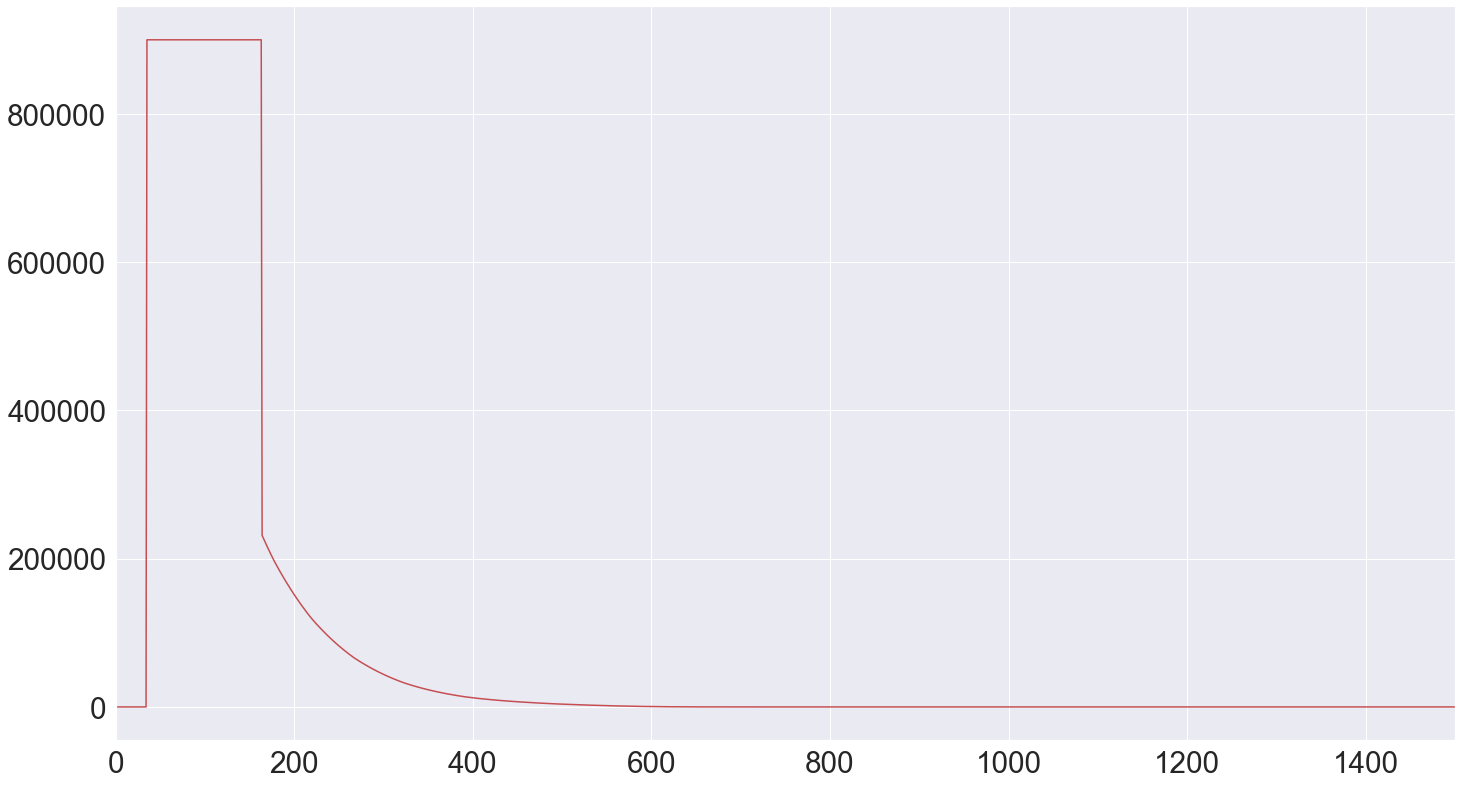

In [195]:
plt.plot(R_array, 'r')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()